In [1]:
!pip install opencv-contrib-python

# %matplotlib inline

In [56]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import colorsys

from scripts import *
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm

plt.rcParams['figure.figsize'] = 20, 5

In [7]:
def iterate_over_mask(img, mask):
    segments = np.unique(mask)
    
    for segment in segments:
        print(segment)
        yield segment, get_subimage(img, mask == segment)
        
def get_luminance_weighted_mask(img_hls, mask_function=get_rule_of_thirds_mask, mask_kwargs={}):
    mask = mask_function(img_hls, **mask_kwargs)

    replacements = {}
    for segment_idx, mask_subimg in iterate_over_mask(img_hls, mask):
        replacements[segment_idx] = np.median(mask_subimg[:,:,1])
        
    flat_mask = mask.flatten()
    return pd.Series(flat_mask).map(replacements).values.reshape(*mask.shape)

def get_subimage(img, mask):
    x = np.max(mask, 1).sum()
    y = np.max(mask, 0).sum()
    
    return np.moveaxis(np.stack(
        [np.extract(mask, img[:,:,0]).reshape(x, y)
        ,np.extract(mask, img[:,:,1]).reshape(x, y)
        ,np.extract(mask, img[:,:,2]).reshape(x, y)]
    ), 0, -1)

def get_palette(hls_palette):
    paleta = list(map(lambda cl: colorsys.hls_to_rgb(cl[0], cl[1], cl[2]), hls_palette))
    
    return paleta

def quantize_img(palette_index_matrix, palette=np_itten_color_wheel):
    shape = palette_index_matrix.shape
    
    return np.take(palette, palette_index_matrix.reshape(-1), axis=0).reshape(shape[0], shape[1], 3)

def quantize_img_color_wheel(img_hls, palette=np_itten_color_wheel):
    shape = img_hls.shape
    palette_index_matrix = get_color_wheel_quantized_img(img_hls, palette)
    
    return np.take(palette, palette_index_matrix.reshape(-1), axis=0).reshape(shape[0], shape[1], 3)

In [8]:
def get_img(img_path):
    img = cv2.imread(img_path)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    
    return img_rgb, img_hls

# Carga archivos

In [9]:
cam = glob.glob('../../Osintgram/output/*.jpg')

In [10]:
mbkmeans = MiniBatchKMeans(n_clusters=32)

In [11]:
img_rgb, img_hls = get_img(cam[0])

In [38]:
for img_path in tqdm(cam):
    img_rgb, img_hls = get_img(img_path)

    norm_img_hls = (get_full_normalized_hls(img_hls).reshape(-1,3) * (1, 0, 1)) + (0, 0.5, 0)
    
    mbkmeans.partial_fit(norm_img_hls)

100%|██████████| 1537/1537 [04:08<00:00,  6.17it/s]


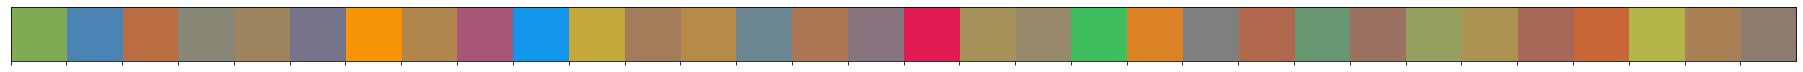

In [39]:
sns.palplot(get_palette(mbkmeans.cluster_centers_))

In [53]:
img = cam[-6]
img_rgb, img_hls = get_img(img)

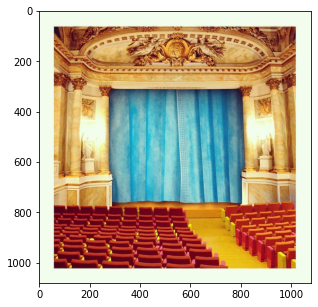

In [54]:
plt.imshow(cv2.cvtColor(img_hls, cv2.COLOR_HLS2RGB))

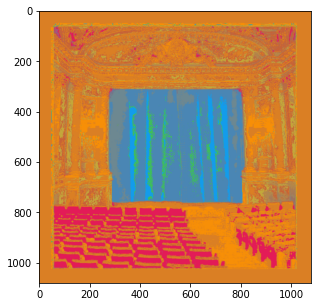

In [55]:
plt.imshow(cv2.cvtColor(np.uint8(quantize_img_color_wheel((img_hls * (1, 0, 1)) + (0, 0.5, 0), mbkmeans.cluster_centers_) * (180, 255, 255)), cv2.COLOR_HLS2RGB))

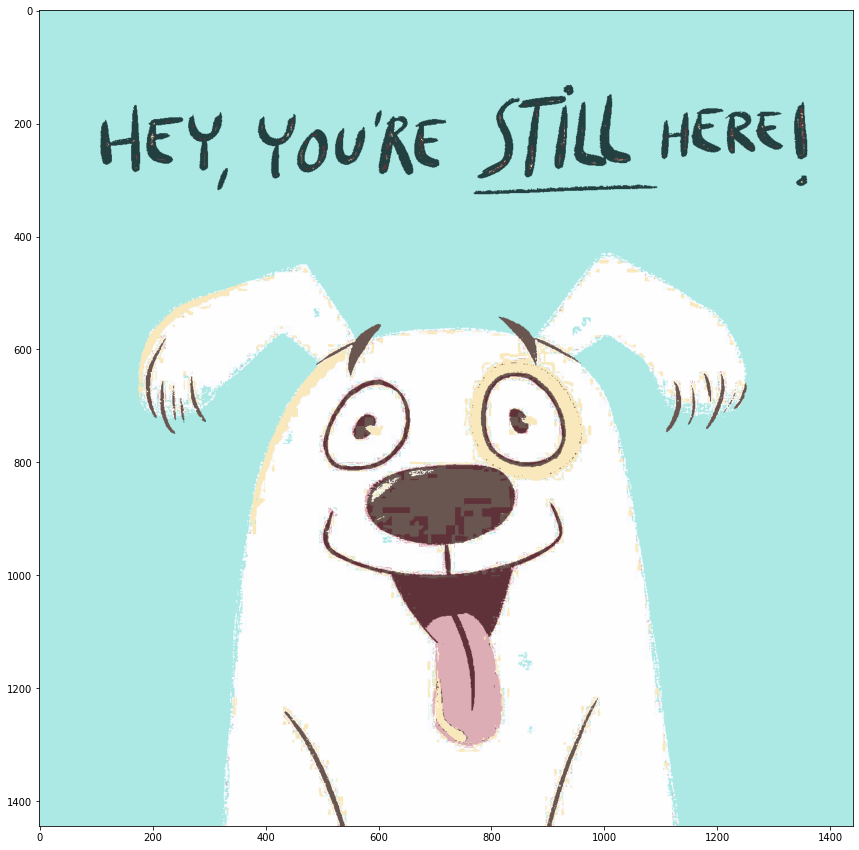

In [15]:
plt.figure(figsize=(20, 15))
plt.imshow(cv2.cvtColor(np.uint8(quantize_img_color_wheel(img_hls, palette) * (180, 255, 255)), cv2.COLOR_HLS2RGB))

In [42]:
colorsys.rgb_to_hls(236/255, 241/255, 244/255)

(0.5625000000000003, 0.9411764705882353, 0.2666666666666671)

In [52]:
[x*255 for x in colorsys.hls_to_rgb(0.55, 0.94, 0.25)]

[235.87499999999997, 241.23, 243.52499999999998]

In [43]:
360*0.5625

202.5

In [ ]:
colorsys.hls_to_rgb()

In [ ]:
hls_palette = len_/ITER

In [166]:
color_clusters = sorted(list(map(tuple, mbkmeans.cluster_centers_)))

In [177]:
paleta = list(map(lambda cl: colorsys.hls_to_rgb(cl[0], cl[2], cl[1]), color_clusters))

In [178]:
sorted_palette = sorted(paleta, key=lambda x: x[2])

In [179]:
ITER = 10
len_ = len(paleta)
chunk_size =  int(len_/ITER)

paletas = []
for i in range(0, len_, chunk_size):
    print(paleta[i:(i+chunk_size)])
    paletas.append(paleta[i:(i+chunk_size)])

[(0.16755225971519816, 0.07602306403331714, 0.01410109146506755), (0.14290357148819355, 0.11704518070391128, 0.09688019493144903), (0.7145373250827969, 0.4751501614148932, 0.11517104840504289), (0.6581077596112158, 0.5848625260138819, 0.42952171230510283), (0.1836510333147071, 0.14923301408293557, 0.057909221267237604), (0.925685884158999, 0.9006109372235008, 0.8042008725914629), (0.9728970410965601, 0.9281169314887786, 0.7208820259544413), (0.9659860396213611, 0.9686485850901274, 0.9616650952972785), (0.028092452151009084, 0.17456019877511378, 0.0652443681053957), (0.06696284339538944, 0.4129360698659909, 0.16098427815736027), (0.06988663224373615, 0.720902478129066, 0.355570281326862), (0.08251078268584489, 0.5961434626464804, 0.41688201487783094)]
[(0.08277423717671084, 0.4719889784154552, 0.34128593694196224), (0.297046955020537, 0.6740772321186433, 0.5885981364779955), (0.08447179128791316, 0.4072133290022561, 0.3476895937257416), (0.16053781821562596, 0.4538579660970853, 0.434242

In [180]:
len_

128

In [181]:
len(paleta)

128

In [189]:
for palet in paletas:
    sns.color_palette(palet)
    plt.show()

In [196]:
sns.color_palette(paletas[5])

[(0.7231324922419702, 0.8965024250369388, 0.9741999045904526),
 (0.7398160025606719, 0.8209044557137438, 0.8578350113870352),
 (0.27992520214754857, 0.5063096927751278, 0.6117383282406892),
 (0.6976966364772237, 0.7794024136805552, 0.817755590846901),
 (0.769261629886098, 0.8261545383073066, 0.8528955922530793),
 (0.15905999386217062, 0.3108943276074866, 0.386544835907382),
 (0.9740792273503188, 0.9818314891749352, 0.9857193136335193),
 (0.8609249201267928, 0.899547949858884, 0.918944653669606),
 (0.609214122414115, 0.712026992768068, 0.7646678588845262),
 (0.7556459651284342, 0.8453515938005831, 0.8920654253047826),
 (0.9937704616280171, 0.9952224363331533, 0.9959873217136636),
 (0.923528169228169, 0.939212507013105, 0.9475618230670869)]

In [128]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [87]:
sns.color_palette[0]

TypeError: 'function' object is not subscriptable

In [83]:
sns.color_palette?

In [82]:
0.55*255

140.25

In [81]:
sns.color_palette(paleta[0:2])

[(0.5579791260636228, 0.9407035315634946, 0.2516837538896807),
 (0.5116504164432096, 0.2666011051466485, 0.5228891829751583)]

array([[0.55797913, 0.25168375, 0.94070353],
       [0.51165042, 0.52288918, 0.26660111],
       [0.58926348, 0.07800731, 0.54696814],
       [0.58485794, 0.86693408, 0.24176829],
       [0.54895794, 0.44490896, 0.49058917],
       [0.62182526, 0.03445671, 0.76587795],
       [0.70498015, 0.05215044, 0.3898968 ],
       [0.50915913, 0.83240202, 0.51318013],
       [0.58522444, 0.06360033, 0.9374762 ],
       [0.52044891, 0.65030336, 0.389697  ],
       [0.54928966, 0.30683395, 0.85720609],
       [0.62110708, 0.03990502, 0.66161419],
       [0.5515781 , 0.82951532, 0.8486662 ],
       [0.37862655, 0.72092938, 0.23994946],
       [0.12104671, 0.52054015, 0.12078013],
       [0.54094318, 0.36497254, 0.55806913],
       [0.51185291, 0.44530917, 0.35038563],
       [0.5293429 , 0.58627634, 0.38485093],
       [0.61517814, 0.0442002 , 0.4550332 ],
       [0.62581029, 0.02483872, 0.83507296],
       [0.62368377, 0.06380173, 0.3273838 ],
       [0.63889486, 0.02356313, 0.49803922],
       [0.

In [36]:
mbkmeans.cluster_centers_ * np.array([360, 1, 1])

array([[2.00872485e+02, 2.51683754e-01, 9.40703532e-01],
       [1.84194150e+02, 5.22889183e-01, 2.66601105e-01],
       [2.12134851e+02, 7.80073114e-02, 5.46968135e-01],
       [2.10548857e+02, 8.66934077e-01, 2.41768289e-01],
       [1.97624859e+02, 4.44908962e-01, 4.90589167e-01],
       [2.23857093e+02, 3.44567090e-02, 7.65877946e-01],
       [2.53792853e+02, 5.21504416e-02, 3.89896802e-01],
       [1.83297286e+02, 8.32402017e-01, 5.13180135e-01],
       [2.10680798e+02, 6.36003333e-02, 9.37476204e-01],
       [1.87361608e+02, 6.50303356e-01, 3.89696998e-01],
       [1.97744279e+02, 3.06833947e-01, 8.57206086e-01],
       [2.23598548e+02, 3.99050218e-02, 6.61614193e-01],
       [1.98568116e+02, 8.29515316e-01, 8.48666198e-01],
       [1.36305557e+02, 7.20929381e-01, 2.39949457e-01],
       [4.35768141e+01, 5.20540154e-01, 1.20780127e-01],
       [1.94739543e+02, 3.64972535e-01, 5.58069130e-01],
       [1.84267047e+02, 4.45309172e-01, 3.50385627e-01],
       [1.90563444e+02, 5.86276

In [ ]:
get_full_normalized_hls(img_hls)

In [16]:
paletted_img = get_color_wheel_quantized_img(img_hls, color_wheel=mbkmeans.cluster_centers_)

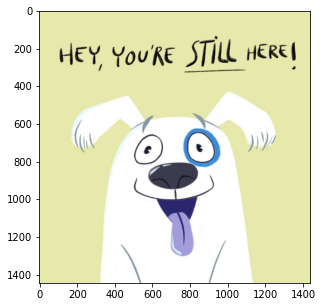

In [19]:
plt.imshow(img)

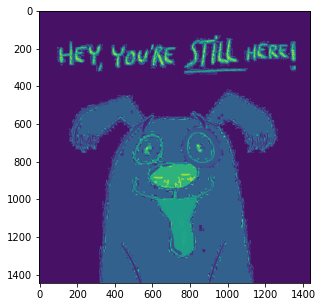

In [17]:
plt.imshow(paletted_img)

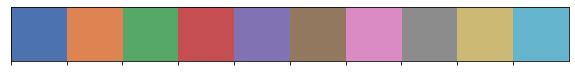

In [22]:
sns.palplot(sns.color_palette("deep", 10))


In [54]:
sns.palplot?

In [25]:
s = sns.color_palette("deep", 10)

In [28]:
type(s)

seaborn.palettes._ColorPalette

In [67]:
[x for x in s[0]]

[0.2980392156862745, 0.4470588235294118, 0.6901960784313725]

In [18]:
plt.imshow(cv2.cvtColor(paletted_img, cv2.COLOR))

SyntaxError: unexpected EOF while parsing (<ipython-input-18-66006b8cbe1b>, line 1)

In [ ]:
r=192
g=64
b=1

In [ ]:
list(map(tuple, a.reshape((2, 2))))

array([[0.55794712, 0.25156706, 0.94067242],
       [0.51608671, 0.52343157, 0.26862671],
       [0.61947447, 0.04836334, 0.54700626],
       [0.5949008 , 0.85616115, 0.24303592],
       [0.53438492, 0.44491507, 0.49059697],
       [0.62059918, 0.03395155, 0.76607293],
       [0.66714201, 0.04041748, 0.39046603],
       [0.47771464, 0.82043357, 0.51216581],
       [0.58535415, 0.06360968, 0.93748692],
       [0.50878388, 0.64560123, 0.39026177],
       [0.55033907, 0.30280492, 0.85537351],
       [0.61953726, 0.03750397, 0.66193195],
       [0.51093181, 0.71486304, 0.65568663],
       [0.39381362, 0.70915115, 0.24021611],
       [0.4404632 , 0.60025517, 0.14262203],
       [0.53772355, 0.365044  , 0.55813776],
       [0.52641887, 0.44942514, 0.35158142],
       [0.51842561, 0.58456605, 0.38509682],
       [0.61652019, 0.04336379, 0.45500424],
       [0.61994076, 0.02349435, 0.83416634],
       [0.61790302, 0.05828091, 0.33334464],
       [0.63889085, 0.02354051, 0.49803922],
       [0.

In [ ]:
for 

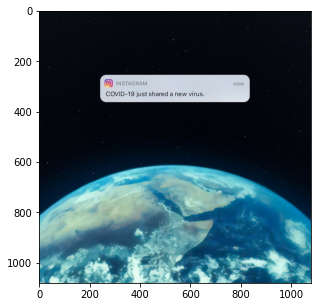

In [7]:
plt.imshow(img_rgb)

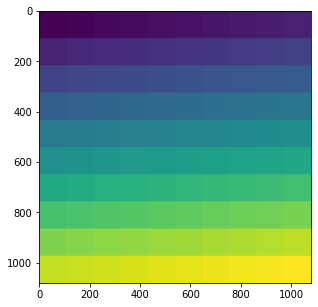

In [12]:
plt.imshow(get_rule_of_thirds_mask(img_rgb, n=10))

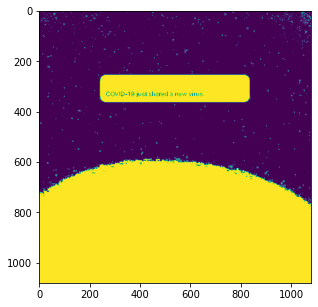

In [80]:
plt.imshow(get_luminosity_quantized_img(img_hls, n_components=2))

In [85]:
get_golden_ratio_mask?

In [94]:
get_golden_ratio_mask(img_hls).shape

(1080, 1080)

In [122]:
(get_golden_ratio_mask(img_rgb) == 0).sum()

15840

In [129]:
get_golden_ratio_mask(img_rgb, side_size=50, anchor_point=(200, 200), start_step='down').shape

(1080, 1080)

In [206]:
def get_golden_ratio_mask(img, side_size=100, anchor_point=(500, 500), start_step='left'):
    start_idx = ALL_STEPS.index(start_step)
    steps = ALL_STEPS[start_idx:] + ALL_STEPS[:start_idx]
    cycle_steps = cycle(steps)

    mask_img = np.ones(img.shape[:2])
    mask_img = mask_img*-1

    b = side_size
    for idx, step in enumerate(cycle_steps):
        a = b 
        b = int(a*phi) 

        if step == 'left':
            anchor_point = anchor_point[0], anchor_point[1] - b
        elif step == 'down':
            anchor_point = anchor_point[0] + a, anchor_point[1]
        elif step == 'right':
            anchor_point = anchor_point[0] - (b - a), anchor_point[1] + a
        else:
            anchor_point = anchor_point[0] - b, anchor_point[1]  - (b - a)

        from_ud, to_ud = anchor_point[0], anchor_point[0] + b
        from_lr, to_lr = anchor_point[1], anchor_point[1] + b

        mask_img[clip_float(from_ud, max_value=img.shape[0]):clip_float(to_ud, max_value=img.shape[0]), clip_float(from_lr, max_value=img.shape[1]):clip_float(to_lr, max_value=img.shape[1])] = idx

        if (from_ud > img.shape[0] or from_ud < 0) and\
            (to_ud > img.shape[0] or to_ud < 0) and\
            (from_lr > img.shape[1] or from_lr < 0) and\
            (to_lr > img.shape[1] or to_lr < 0):
            break

    return mask_img

In [207]:
mask = get_golden_ratio_mask(img_hls, side_size=50, anchor_point=(200, 200), start_step='down') == -1

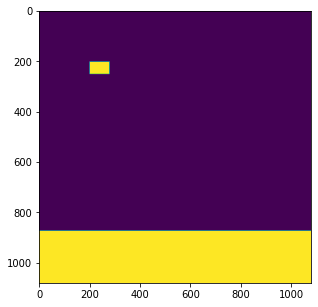

In [208]:
plt.imshow(mask)

In [195]:
plt.imshow(get_luminance_weighted_mask(img_rgb, mask_function=get_golden_ratio_mask, mask_kwargs={
    'side_size': 50
    ,'anchor_point': (200, 200)
    ,'start_step': 'down'
}))

-1.0


ValueError: cannot reshape array of size 228511 into shape (257,1080)

In [15]:
get_subimage?

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

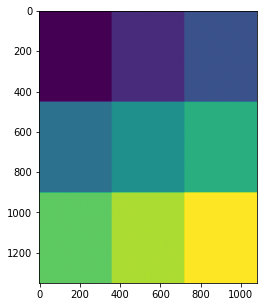

In [13]:
plt.imshow(get_rule_of_thirds_mask(img))

(array([ 82255.,  36219.,  77732., 204898., 607092.,  94316., 179414.,
        115097.,   5851.,  21286.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

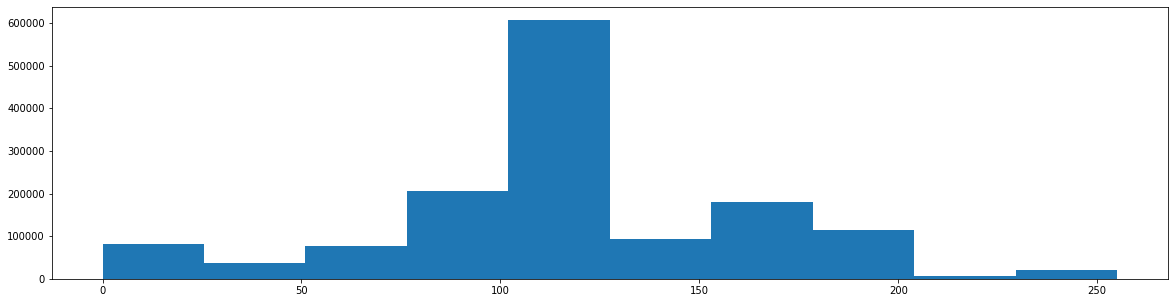

In [848]:
plt.hist(img_hls[:,:,1].reshape(-1))

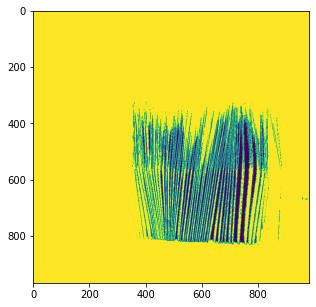

In [787]:
plt.imshow(get_color_wheel_quantized_img(img_hls, color_wheel=np_wb_itten_color_wheel) == 10)

In [768]:
np.moveaxis(get_full_normalized_hls(img_hls), 0, -2).shape

(600, 480, 3)

In [499]:
get_full_normalized_hls(img_hls).reshape(-1,3).shape

(1458000, 3)

In [511]:
np_itten_color_wheel.T.shape

(3, 12)

(1350, 1080)

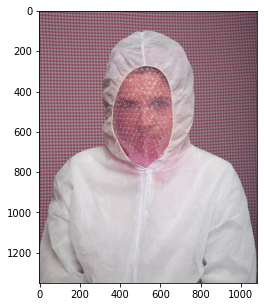

In [575]:
plt.imshow(img_rgb)

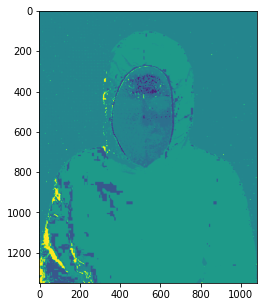

In [590]:
plt.imshow(itten_img)

## itten_img.max()

In [561]:
plt.imshow()

TypeError: imshow() missing 1 required positional argument: 'X'

In [332]:
(itten_img == 0)**np_itten_color_wheel[:,0]

ValueError: operands could not be broadcast together with shapes (1350,1080) (12,) 

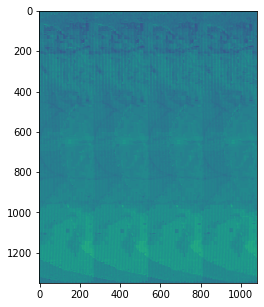

In [322]:
plt.imshow(itten_img)

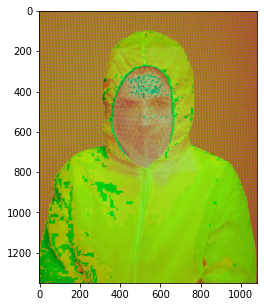

In [324]:
plt.imshow(img_hls)

In [274]:
np.subtract(get_scaled_hls(img_hls), np_itten_color_wheel.T, axi)

ValueError: operands could not be broadcast together with shapes (1080,1350,3) (3,12) 

In [271]:
np.dot(get_scaled_hls(img_hls), np_itten_color_wheel.T)

array([[[18444.58356863, 14616.50341176, 11136.5305098 , ...,
         65424.21505882, 45240.23980392, 24360.33580392],
        [18444.57882353, 14616.49647059, 11136.51490196, ...,
         65424.22078431, 45240.25411765, 24360.34392157],
        [18550.57784314, 14700.49164706, 11200.49823529, ...,
         65800.23086275, 45500.27643137, 24500.3585098 ],
        ...,
        [18020.48298039, 14280.43035294, 10880.49345098, ...,
         63920.142     , 44200.12015686, 23800.22568627],
        [18020.47192157, 14280.42047059, 10880.48203922, ...,
         63920.13882353, 44200.11756863, 23800.22062745],
        [18020.46454902, 14280.41388235, 10880.47443137, ...,
         63920.13670588, 44200.11584314, 23800.2172549 ]],

       [[18550.58227451, 14700.50329412, 11200.53329412, ...,
         65800.21196078, 45500.23356863, 24500.3312549 ],
        [18444.57380392, 14616.49364706, 11136.51631373, ...,
         65424.21498039, 45240.24345098, 24360.33529412],
        [18550.57156863, 

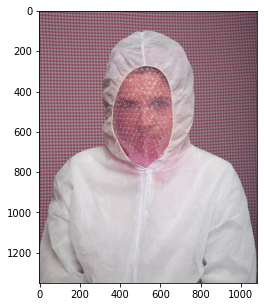

In [260]:
plt.imshow(img_rgb)

## l.min()

In [ ]:
def 

In [240]:
img_rgb[0,0,:]

array([181, 193, 205], dtype=uint8)

In [241]:
h

array([[210., 210., 210., ..., 210., 210., 210.],
       [210., 210., 210., ..., 210., 210., 210.],
       [210., 210., 210., ..., 210., 210., 210.],
       ...,
       [224., 224., 224., ..., 218., 218., 218.],
       [224., 224., 224., ..., 218., 218., 218.],
       [224., 224., 224., ..., 218., 218., 218.]])

In [246]:
img_hls

array([[[105, 193,  49],
        [105, 193,  49],
        [105, 193,  49],
        ...,
        [105, 191,  48],
        [105, 191,  48],
        [105, 191,  48]],

       [[105, 193,  49],
        [105, 193,  49],
        [105, 193,  49],
        ...,
        [105, 191,  48],
        [105, 191,  48],
        [105, 191,  48]],

       [[105, 193,  49],
        [105, 193,  49],
        [105, 193,  49],
        ...,
        [105, 191,  48],
        [105, 191,  48],
        [105, 191,  48]],

       ...,

       [[112, 102,  31],
        [112, 100,  32],
        [112,  96,  33],
        ...,
        [109, 104,  35],
        [109, 106,  35],
        [109, 108,  34]],

       [[112, 104,  31],
        [112, 102,  31],
        [112,  96,  33],
        ...,
        [109, 106,  35],
        [109, 108,  34],
        [109, 114,  33]],

       [[112, 104,  31],
        [112, 102,  31],
        [112,  96,  33],
        ...,
        [109, 108,  34],
        [109, 112,  33],
        [109, 118,  31]]

array([[[210.,  76.,  20.],
        [210.,  76.,  20.],
        [210.,  76.,  20.],
        ...,
        [224.,  40.,  13.],
        [224.,  41.,  13.],
        [224.,  41.,  13.]],

       [[210.,  76.,  20.],
        [210.,  76.,  20.],
        [210.,  76.,  20.],
        ...,
        [224.,  40.,  13.],
        [224.,  40.,  13.],
        [224.,  40.,  13.]],

       [[210.,  76.,  20.],
        [210.,  76.,  20.],
        [210.,  76.,  20.],
        ...,
        [224.,  38.,  13.],
        [224.,  38.,  13.],
        [224.,  38.,  13.]],

       ...,

       [[210.,  75.,  19.],
        [210.,  75.,  19.],
        [210.,  75.,  19.],
        ...,
        [218.,  41.,  14.],
        [218.,  42.,  14.],
        [218.,  43.,  14.]],

       [[210.,  75.,  19.],
        [210.,  75.,  19.],
        [210.,  75.,  19.],
        ...,
        [218.,  42.,  14.],
        [218.,  43.,  14.],
        [218.,  44.,  13.]],

       [[210.,  75.,  19.],
        [210.,  75.,  19.],
        [210.,  

In [242]:
s

array([[20., 20., 20., ..., 19., 19., 19.],
       [20., 20., 20., ..., 19., 19., 19.],
       [20., 20., 20., ..., 19., 19., 19.],
       ...,
       [13., 13., 13., ..., 14., 14., 14.],
       [13., 13., 13., ..., 14., 14., 13.],
       [13., 13., 13., ..., 14., 13., 13.]])

In [243]:
l

array([[76., 76., 76., ..., 75., 75., 75.],
       [76., 76., 76., ..., 75., 75., 75.],
       [76., 76., 76., ..., 75., 75., 75.],
       ...,
       [40., 40., 38., ..., 41., 42., 43.],
       [41., 40., 38., ..., 42., 43., 45.],
       [41., 40., 38., ..., 43., 44., 47.]])

array([[0.14117647, 0.14117647, 0.14117647, ..., 0.10980392, 0.10980392,
        0.10980392],
       [0.14117647, 0.14117647, 0.14117647, ..., 0.50196078, 0.10980392,
        0.10980392],
       [0.14117647, 0.14117647, 0.14117647, ..., 0.89411765, 0.89411765,
        0.89411765],
       ...,
       [0.75294118, 0.75294118, 0.75294118, ..., 0.6745098 , 0.6745098 ,
        0.28235294],
       [0.75294118, 0.75294118, 0.75294118, ..., 0.6745098 , 0.28235294,
        0.89411765],
       [0.75294118, 0.75294118, 0.75294118, ..., 0.28235294, 0.89411765,
        0.10980392]])

In [149]:
h, l, s = cv2.split(img_hls)
l = 

In [158]:
cv2.merge([h, l, s])

error: OpenCV(4.5.2) /tmp/pip-req-build-rcdoave0/opencv/modules/core/src/merge.dispatch.cpp:129: error: (-215:Assertion failed) mv[i].size == mv[0].size && mv[i].depth() == depth in function 'merge'


In [143]:
h, l, s = cv2.split(img_hls)


In [140]:
s.shape

(1350, 1080)

In [117]:
img_hls[:,:,2]

array([[49, 49, 49, ..., 48, 48, 48],
       [49, 49, 49, ..., 48, 48, 48],
       [49, 49, 49, ..., 48, 48, 48],
       ...,
       [31, 32, 33, ..., 35, 35, 34],
       [31, 31, 33, ..., 35, 34, 33],
       [31, 31, 33, ..., 34, 33, 31]], dtype=uint8)

In [118]:
img_hls.reshape(-1, 3)

array([[105, 193,  49],
       [105, 193,  49],
       [105, 193,  49],
       ...,
       [109, 108,  34],
       [109, 112,  33],
       [109, 118,  31]], dtype=uint8)

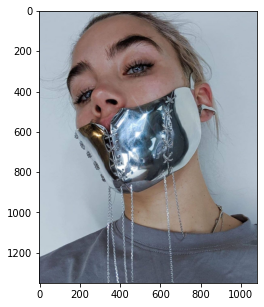

In [99]:
plt.imshow(img_rgb)

In [100]:
img_rgb.reshape(-1, 3)

array([[181, 193, 205],
       [181, 193, 205],
       [181, 193, 205],
       ...,
       [ 93, 104, 122],
       [ 97, 108, 126],
       [103, 114, 132]], dtype=uint8)

In [55]:
img_hls[:,:,0]

array([[105, 105, 105, ..., 105, 105, 105],
       [105, 105, 105, ..., 105, 105, 105],
       [105, 105, 105, ..., 105, 105, 105],
       ...,
       [112, 112, 112, ..., 109, 109, 109],
       [112, 112, 112, ..., 109, 109, 109],
       [112, 112, 112, ..., 109, 109, 109]], dtype=uint8)

In [56]:
img_hls[:,:,1]

array([[193, 193, 193, ..., 191, 191, 191],
       [193, 193, 193, ..., 191, 191, 191],
       [193, 193, 193, ..., 191, 191, 191],
       ...,
       [102, 100,  96, ..., 104, 106, 108],
       [104, 102,  96, ..., 106, 108, 114],
       [104, 102,  96, ..., 108, 112, 118]], dtype=uint8)

In [57]:
img_hls[:,:,2]

array([[49, 49, 49, ..., 48, 48, 48],
       [49, 49, 49, ..., 48, 48, 48],
       [49, 49, 49, ..., 48, 48, 48],
       ...,
       [31, 32, 33, ..., 35, 35, 34],
       [31, 31, 33, ..., 35, 34, 33],
       [31, 31, 33, ..., 34, 33, 31]], dtype=uint8)

In [78]:
img_hls.reshape(-1, 3)

array([[[105, 193,  49],
        [105, 193,  49],
        [105, 193,  49],
        ...,
        [105, 195,  51],
        [105, 195,  51],
        [105, 195,  51]],

       [[105, 194,  50],
        [105, 194,  50],
        [105, 194,  50],
        ...,
        [105, 120,  19],
        [105, 135,  19],
        [104, 151,  23]],

       [[101, 179,  35],
        [100, 180,  37],
        [101, 180,  35],
        ...,
        [101, 183,  37],
        [101, 184,  37],
        [101, 185,  38]],

       ...,

       [[112,  99,  28],
        [112, 103,  27],
        [112,  87,  32],
        ...,
        [112,  90,  31],
        [112,  92,  30],
        [112,  90,  31]],

       [[112,  81,  35],
        [112,  87,  32],
        [112,  96,  29],
        ...,
        [109,  88,  31],
        [109,  86,  31],
        [109,  86,  31]],

       [[111,  89,  29],
        [111,  84,  30],
        [111,  82,  31],
        ...,
        [109, 108,  34],
        [109, 112,  33],
        [109, 118,  31]]

In [69]:
np.moveaxis(img_hls, -1, 0).reshape(3, -1).T

array([[105, 193,  49],
       [105, 193,  49],
       [105, 193,  49],
       ...,
       [109, 108,  34],
       [109, 112,  33],
       [109, 118,  31]], dtype=uint8)

In [20]:
mask = get_golden_ratio_mask(img, anchor_point=(200, 100), start_step='down', side_size=5)
mask_rep = np.repeat(get_rule_of_thirds_mask(img).reshape(img.shape[0], img.shape[1], 1), 3, axis=2)

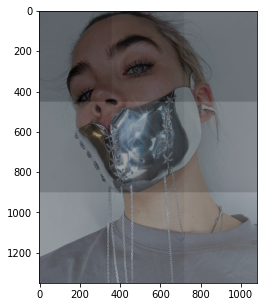

In [51]:
plt.imshow(cv2.addWeighted(np.uint8(mask_rep*16), 0.5, img, 0.5, 2))